In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats as ss
import math
import os.path
from os import path
import sys
from datetime import datetime
from dataCleaning import DataCleaner

In [11]:
data_months = range(1, 13)
data_years = range(2018, 2021)

topK = 20
data = {}
cleaner = DataCleaner(columns=["OptionType", "expirydate", "date", "strike", "spotclose", "close2", "volume"],
                          date_columns=["date", "expirydate"], verbose=False)
for year in data_years:
    for month in data_months:
        if month < 10:
            name = "SPX_{}0{}_1day".format(year, month)
        else:
            name = "SPX_{}{}_1day".format(year, month)
        if not path.exists("./SPXdata/{}.csv".format(name)):
            continue
        cleaner.insert_data(data, name, "USD3MTD156N", topK)
#         print("Added Year: {}, Month: {} data".format(year, month))

cleaner.get_num_days()
cleaner.get_num_observation()

Attached 563 days of data
Attached 5630 option observations


5630

## Step 1: Initialize prior parameters

In [13]:
import warnings
warnings.simplefilter('error')

### initialize priors omega, alpha, beta, W, v

## W ~ InverseGamma(a_0, b_0) ############################################################################

a_0 = 1
b_0 = 1
#sampleing
phi = np.random.gamma(shape = a_0, scale = 1/b_0)
W = 1/phi


## Beta = (omega, alpha, beta) ~ MVN(mu_0, Lambda_0^{-1}/phi) ############################################
Lambda_0 = np.array([[1000000, 0, 0],
                     [0, 10000, 0],
                     [0, 0, 10000]])
mu_0 = np.array([0.000004, 0.45, 0.45])
#sampleing

def SampleBeta(temp_mu, temp_Sigma):
    HaveBeta = False
    while not HaveBeta:
        #Sample beta
        beta_mu = temp_mu[2]
        beta_Sigma = temp_Sigma[2,2]
        beta_left = ss.norm.cdf(0.000001, beta_mu, beta_Sigma)
        beta_right = ss.norm.cdf(1, beta_mu, beta_Sigma)
        beta_inv = ss.uniform.rvs(beta_left, beta_right, 1)
        beta = ss.norm.ppf(beta_inv, beta_mu, beta_Sigma)

        #Sample alpha
        alpha_mu_cdt = temp_mu[1] + temp_Sigma[1,2] / temp_Sigma[2,2] * (beta - temp_mu[2])
        alpha_Sigma_cdt = temp_Sigma[1,1] - temp_Sigma[1,2] / temp_Sigma[2,2] * temp_Sigma[2,1]
        alpha_left = ss.norm.cdf(0.000001, alpha_mu_cdt, alpha_Sigma_cdt)
        alpha_right = ss.norm.cdf(1, alpha_mu_cdt, alpha_Sigma_cdt)
        alpha_inv = ss.uniform.rvs(alpha_left, alpha_right, 1)
        alpha = ss.norm.ppf(alpha_inv, alpha_mu_cdt, alpha_Sigma_cdt)

        #Sample omega
        prev = np.array([[alpha], 
                         [beta]]).reshape([2,])

        omega_mu_cdt = temp_mu[0] - np.matmul(np.matmul( temp_Sigma[0, 1:], np.linalg.inv(temp_Sigma[1:, 1:])), prev-temp_mu[1:] )
        omega_Sigma_cdt = temp_Sigma[0,0] - np.matmul(np.matmul(temp_Sigma[0, 1:], np.linalg.inv(temp_Sigma[1:, 1:])) , temp_Sigma[1:, 0])
        omega_left = ss.norm.cdf(0.000001, omega_mu_cdt, omega_Sigma_cdt)
        omega_inv = ss.uniform.rvs(omega_left, 1, 1)

        omega = ss.norm.ppf(omega_inv, omega_mu_cdt, omega_Sigma_cdt)

        if omega > 0 and alpha > 0 and alpha < 1 and beta > 0 and beta < 1:
            HaveBeta = True
    return np.array([omega, alpha, beta])

Beta = SampleBeta(mu_0, np.linalg.inv(Lambda_0) / phi)



# Beta = np.array([0.82012376, 0.62187522, 0.26997804])
omega = Beta[0]
alpha = Beta[1]
beta = Beta[2]


## v ~ InverseGamma(delta, epsilon) ######################################################################
delta = 1
epsilon = 1
#sampleing
tau = np.random.gamma(shape= delta, scale = 1/epsilon)
v = 1/tau


## theta_0 ~ normal(m_0, C_0) ############################################################################
m_0 = 0.000002
C_0 = 0.0015
theta_0 = np.random.normal(m_0, C_0)

omega = 0.000002


# Prepare update g_{t} and BS f_{ti} function

def g_t(u_t, theta_t_1, o=omega, a=alpha, b=beta):
    return o + a*  (u_t**2) + b * theta_t_1

def f_t_parallel(theta_t, p_t, r_t, K_t, T_t):
    """
    :params K_t is a 1D np array
    :params T_t is a 1D np array
    """
    d_pls = (np.log(p_t/ K_t) + np.multiply( r_t+theta_t/2, T_t)) / np.sqrt(theta_t * T_t)
    d_mns = (np.log(p_t/ K_t) + np.multiply( r_t-theta_t/2, T_t)) / np.sqrt(theta_t * T_t)
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(- r_t * T_t)), norm.cdf(d_mns))
    return y_t


def F_t_Trans_parallel(theta_t, p_t, r_t, K_t, T_t):
    d_pls = (np.log(p_t/ K_t) + np.multiply( r_t+theta_t/2, T_t)) / np.sqrt(theta_t * T_t) 
    d_mns = (np.log(p_t/ K_t) + np.multiply( r_t-theta_t/2, T_t)) / np.sqrt(theta_t * T_t)
    dd_pls = -1/2*( np.log(p_t/K_t) / np.sqrt(T_t) + r_t * np.sqrt(T_t)) / np.sqrt(theta_t**3)   +   1/4 * np.sqrt(T_t) / np.sqrt(theta_t)
    dd_mns = -1/2*( np.log(p_t/K_t) / np.sqrt(T_t) + r_t * np.sqrt(T_t)) / np.sqrt(theta_t**3)   -   1/4 * np.sqrt(T_t) / np.sqrt(theta_t)
    return p_t*norm.pdf(d_pls)*dd_pls - K_t*np.exp(-r_t*T_t)*norm.pdf(d_mns)*dd_mns
    
    
def SampleTheta(temp_mu, temp_Sigma):
    HaveTheta = False
#     print(temp_mu)
#     print(temp_Sigma)
    while not HaveTheta:
        #Sample beta
        theta_left = ss.norm.cdf(0, temp_mu, temp_Sigma)
        theta_inv = ss.uniform.rvs(theta_left, 1, 1)
        theta = ss.norm.ppf(theta_inv, temp_mu, temp_Sigma)

        if theta > 0: 
            HaveTheta = True
    return float(theta)



################### MCMC ===================

traj_W = []
traj_omega = []
traj_alpha = []
traj_beta = []
traj_v = []
traj_theta_0 = []

dynamics_volatility = []

for itr in range(10000):
    Ms = [m_0] # Don't forget to remove the first element which is for theta_0
    Cs = [C_0] # Don't forget to remove the first element which is for theta_0

    # Record U for backward smoothing
    Us = []

    # Record P, R, K, T
    Rs = []


    all_days = sorted(list(data.keys()))
    for day in all_days:
        # get observable data
        ## Stock Wise and market wise data
        p_t = data[day][0]["spotclose"].values[0]
        r_t = (data[day][1] + 1)**(1/260) - 1
        u_t = data[day][2]
        Us.append(u_t)

        ## Option wise data
        y_t = data[day][0]["close2"].values
        K_t = data[day][0]["strike"].values
        today = [d.date() for d in data[day][0]["date"]]
        expireday = [d.date() for d in data[day][0]["expirydate"]]
        T_t = np.busday_count(today, expireday)

        # Calculate model wise data
        a_t = g_t(u_t, Ms[-1], omega, alpha, beta)
        G_t = beta
        R_t = G_t**2 * Cs[-1] + W
        F_t_Trans = F_t_Trans_parallel(a_t, p_t, r_t, K_t, T_t)
        h_t = f_t_parallel(a_t, p_t, r_t, K_t, T_t) - F_t_Trans*a_t
        xi_t = np.maximum(y_t - h_t, 0)



        # Update parameter
#         print(day)
#         print("Now u_t =" + str(u_t))  ############################################################################################
#         print("Now a_t =" + str(a_t))  ############################################################################################
#         print("Now p_t =" + str(p_t))  ############################################################################################
#         print("Now r_t =" + str(r_t))  ############################################################################################
#         print("Now K_t =" + str(K_t))  ############################################################################################
#         print("Now T_t =" + str(T_t))  ############################################################################################
#         print("m_{t-1} = "+ str(Ms[-1]))  ############################################################################################
#         print("a_t = "+ str(a_t))  ############################################################################################
#         print("y_t = "+ str(y_t) )  ############################################################################################
#         print("True f = "+ str(f_t_parallel(a_t, p_t, r_t, K_t, T_t)) )  ############################################################################################
#         print("linear F = "+ str(F_t_Trans*a_t) )  ############################################################################################
#         print("xi_t = "+ str(xi_t))   ############################################################################################
#         print()  ############################################################################################
#         print()  ############################################################################################


        m_t = (R_t * np.sum(F_t_Trans*xi_t) + v*a_t) / (np.sum(F_t_Trans*F_t_Trans) + v)
        C_t = (v* R_t) / (np.sum(F_t_Trans*F_t_Trans) + v)

        Ms.append(m_t)
        Cs.append(C_t)


    theta_back = []
    Ms_star = [Ms[-1]]
    Cs_star = [Cs[-1]]
    T = len(Ms)
    
#     print(Ms)
    
    for t in range(T-1, 0, -1):
        theta_t_backward = SampleTheta(Ms_star[-1], Cs_star[-1])
        theta_back.insert(0, float(theta_t_backward))
        G_t = beta
        C_t_1 = Cs[t-1]
        R_t = G_t*C_t_1*G_t + W
        J_t_1 = C_t_1*G_t*(1/R_t)

        u_t = Us[t-1]
        m_t_1_backward = Ms[t-1] + J_t_1*(theta_t_backward-g_t(Ms[t-1], u_t, o=omega, a=alpha, b=beta))
        C_t_1_backward = C_t_1 - J_t_1*R_t*J_t_1

        Ms_star.append(m_t_1_backward)
        Cs_star.append(C_t_1_backward)

    theta0 = np.random.normal(Ms_star[-1], Cs_star[-1])
    theta_back.insert(0, float(theta_0))
    T -= 1

    dynamics_volatility.append(theta_back)

    # Make Design Matrix
    Theta = np.array(theta_back[1:]).reshape([T,1])
    component1=np.ones((T, 1))
    component2=np.multiply(np.array(Us), np.array(Us)).reshape([T,1])
    component3=np.array(theta_back[:-1]).reshape([T,1])
    X = np.concatenate( (component1, component2, component3), axis=1)

    Lambda_n = np.matmul(X.T, X) + Lambda_0
    mu_n = np.matmul(np.linalg.inv(Lambda_n), (np.matmul(Lambda_0, mu_0.reshape([3,1])) + np.matmul(X.T, Theta)))
    a_n = a_0 + T/2
    b_n = b_0 + 1/2*(np.matmul(Theta.T, Theta) + np.matmul(mu_0.T, np.matmul(Lambda_0, mu_0)) + np.matmul(mu_n.T, np.matmul(Lambda_n, mu_n)))

    phi_new = np.random.gamma(a_n, 1/b_n)
    W_new = 1/phi_new
    
    Beta_new = SampleBeta(mu_n.reshape(3), np.linalg.inv(Lambda_n)/phi_new)

    delta_y_f = 0
    all_days = sorted(list(data.keys()))
    for day_idx in range(len(all_days)):
        # get observable data
        ## Stock Wise and market wise data
        p_t = data[day][0]["spotclose"].values[0]
        r_t = math.log(data[day][1], 260)

        ## Option wise data
        y_t = data[day][0]["close2"].values
        K_t = data[day][0]["strike"].values
        today = [d.date() for d in data[day][0]["date"]]
        expireday = [d.date() for d in data[day][0]["expirydate"]]
        T_t = np.busday_count(today, expireday)

        option_price_hat = f_t_parallel(max(0, theta_back[day_idx+1]), p_t, r_t, K_t, T_t)
        delta_y_f += np.sum(np.power(y_t - option_price_hat, 2))




    delta_new = delta + T*topK/2
    epsilon_new = epsilon + 1/2*delta_y_f

    tau_new = np.random.gamma(delta_new, 1/epsilon_new)
    v_new = 1/tau_new
    
    ## Update all parameters
    phi = phi_new
    W = W_new
    Beta = Beta_new
    omega = Beta[0]
    alpha = Beta[1]
    beta = Beta[2]
    tau = tau_new
    v = v_new
    theta_0 = theta0
    
    traj_W.append(float(W))
    traj_omega.append(float(omega))
    traj_alpha.append(float(alpha))
    traj_beta.append(float(beta))
    traj_v.append(float(v))
    traj_theta_0.append(float(theta_0))
    
    sys.stdout.write("\rMCMC {} iteration finished".format(str(itr)))
    sys.stdout.flush()
    
volatility = np.array(dynamics_volatility)


MCMC 9999 iteration finished

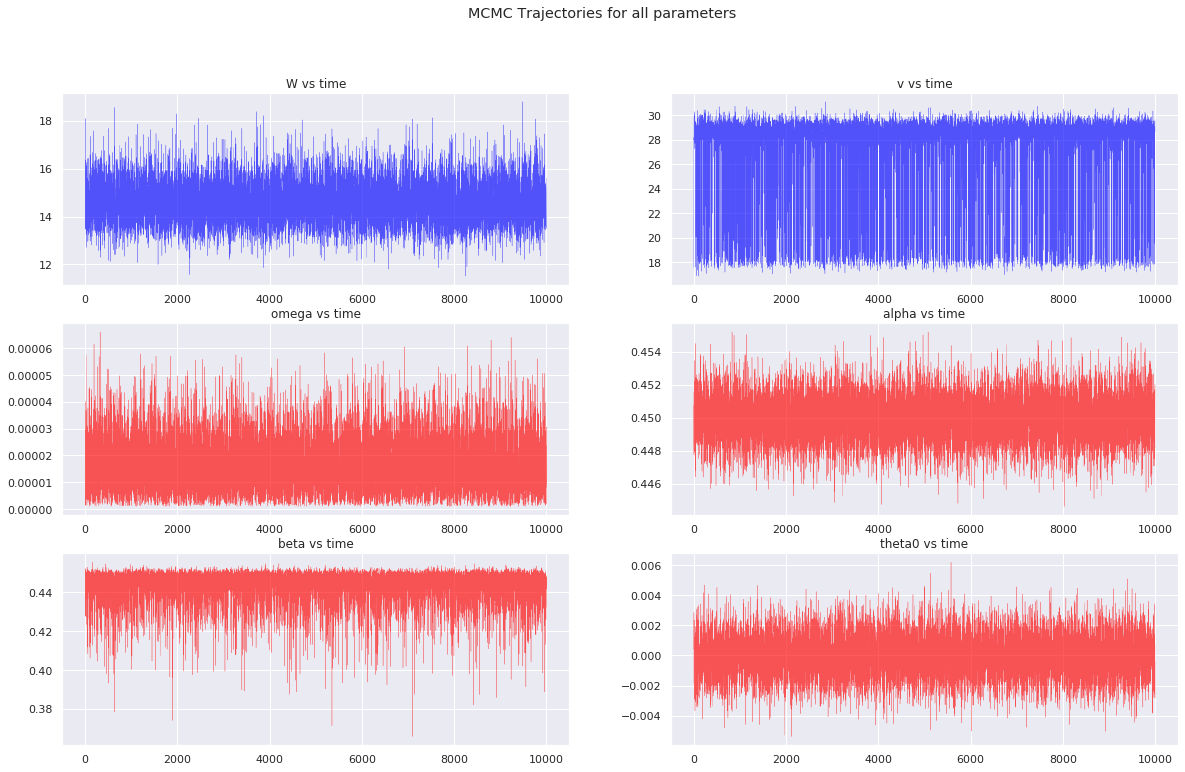

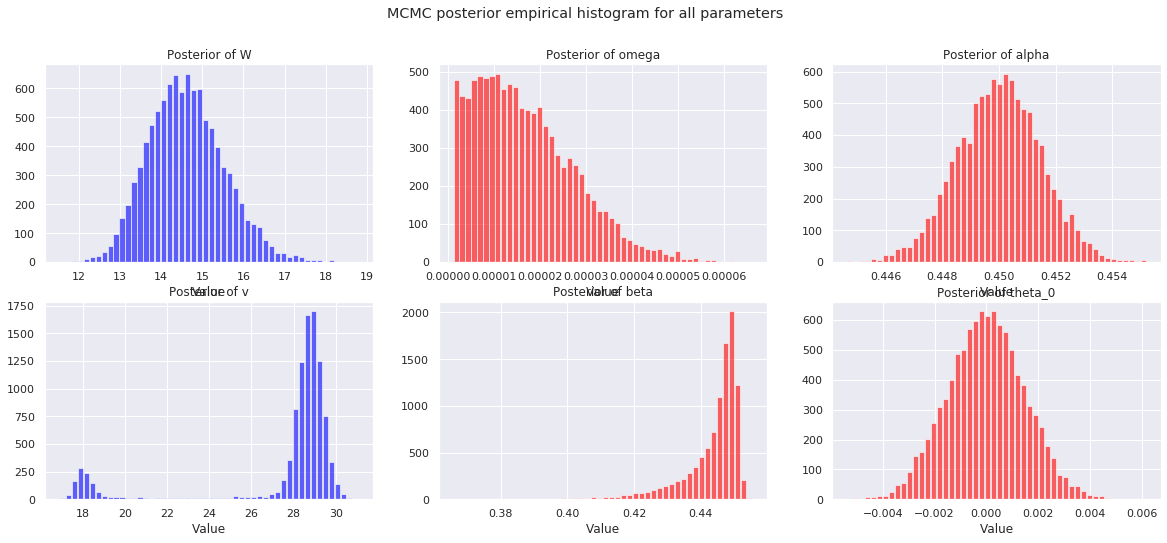

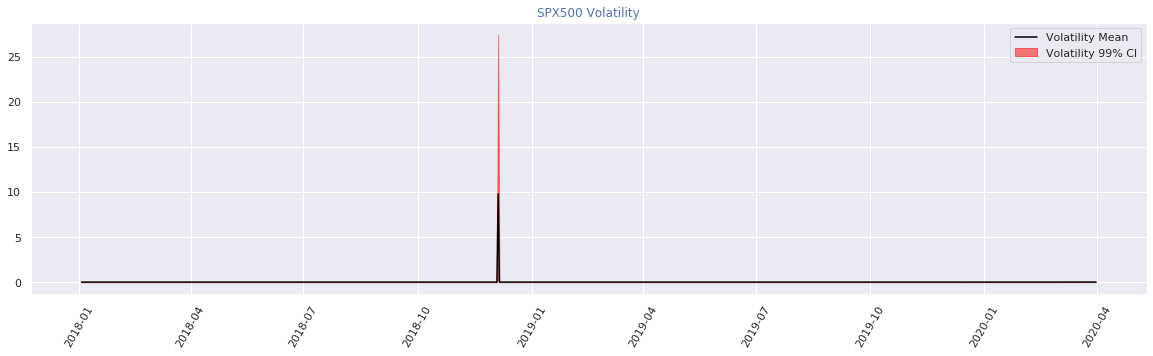

In [27]:
##### sns.set()
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
fig.suptitle("MCMC Trajectories for all parameters")
ax[0,0].set_title('W vs time'.format("seaborn"))   
ax[0,0].plot([j for j in range(len(traj_W))], [j for j in traj_W], color="blue", alpha = 0.65 , linewidth = 0.3)

ax[0,1].set_title('v vs time'.format("seaborn"))   
ax[0,1].plot([j for j in range(len(traj_v))], [j/1000 for j in traj_v], color="blue", alpha = 0.65, linewidth = 0.3)

ax[1,0].set_title('omega vs time'.format("seaborn"))   
ax[1,0].plot([j for j in range(len(traj_omega))], [j for j in traj_omega], color="red", alpha = 0.65, linewidth = 0.3)

ax[1,1].set_title('alpha vs time'.format("seaborn"))   
ax[1,1].plot([j for j in range(len(traj_alpha))], [j for j in traj_alpha], color="red", alpha = 0.65, linewidth = 0.3)

ax[2,0].set_title('beta vs time'.format("seaborn"))   
ax[2,0].plot([j for j in range(len(traj_beta))], [j for j in traj_beta], color="red", alpha = 0.65, linewidth = 0.3)

ax[2,1].set_title('theta0 vs time'.format("seaborn"))   
ax[2,1].plot([j for j in range(len(traj_theta_0))], [j for j in traj_theta_0], color="red", alpha = 0.65, linewidth = 0.3)
plt.show()

fig.savefig('MCMC_trajectories_for_all_parameters.png', dpi=fig.dpi)


fig, a = plt.subplots(2,3, figsize=(20, 8))
fig.suptitle("MCMC posterior empirical histogram for all parameters")
a[0, 0].hist(x=traj_W, bins=50, color='blue', alpha=0.6, rwidth=0.85)
a[0, 0].set_xlabel('Value')
a[0, 0].set_title('Posterior of W')

a[1, 0].hist(x=np.array(traj_v)/1000, bins=50, color='blue', alpha=0.6, rwidth=0.85)
a[1, 0].set_xlabel('Value')
a[1, 0].set_title('Posterior of v')

a[0, 1].hist(x=traj_omega, bins=50, color='red', alpha=0.6, rwidth=0.85)
a[0, 1].set_xlabel('Value')
a[0, 1].set_title('Posterior of omega')

a[0, 2].hist(x=traj_alpha, bins=50, color='red', alpha=0.6, rwidth=0.85)
a[0, 2].set_xlabel('Value')
a[0, 2].set_title('Posterior of alpha')

a[1, 1].hist(x=traj_beta, bins=50, color='red', alpha=0.6, rwidth=0.85)
a[1, 1].set_xlabel('Value')
a[1, 1].set_title('Posterior of beta')

a[1, 2].hist(x=traj_theta_0, bins=50, color='red', alpha=0.6, rwidth=0.85)
a[1, 2].set_xlabel('Value')
a[1, 2].set_title('Posterior of theta_0')
plt.show()
fig.savefig('MCMC_posterior_empirical_histogram_for_all_parameters.png', dpi=fig.dpi)

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('SPX500 Volatility'.format("seaborn"), color='C0')   
low = np.quantile(volatility, 0.025, axis=0)
high = np.quantile(volatility, 0.975, axis=0)
mean = np.mean(volatility, axis=0)
DeltaUs = np.abs(np.array(Us[1:]) - np.array(Us[:-1]))

ax.plot(all_days[1:], mean[2:], color="black")
ax.fill_between([j for j in all_days[1:]], high[2:], low[2:], color='red', alpha=.5)
#ax.plot(all_days[1:], DeltaUs, color = "green", linestyle="--", alpha = 0.5)
ax.legend(['Volatility Mean', "Volatility 99% CI"])
plt.xticks(rotation=60)
plt.show()


In [ ]:
theta_back = []
Ms_star = [Ms[-1]]
Cs_star = [Cs[-1]]
T = len(Ms)


def positive_theta(theta_instance):
    if theta_instance < 0:
        return False
    return True

for t in range(T-1, 0, -1):
    sys.stdout.write("\r The {} ".format(str(t)))
    sys.stdout.flush()
    theta_t_backward = SampleTheta(Ms_star[-1], Cs_star[-1])

        
    theta_back.insert(0, float(theta_t_backward))
    G_t = beta
    C_t_1 = Cs[t-1]
    R_t = G_t*C_t_1*G_t + W
    J_t_1 = C_t_1*G_t*(1/R_t)
    
    u_t = Us[t-1]
    m_t_1_backward = Ms[t-1] + J_t_1*(theta_t_backward-g_t(Ms[t-1], u_t, o=omega, a=alpha, b=beta))
    C_t_1_backward = C_t_1 - J_t_1*R_t*J_t_1
    
    Ms_star.append(m_t_1_backward)
    Cs_star.append(C_t_1_backward)

theta0 = np.random.normal(Ms_star[-1], Cs_star[-1])
theta_back.insert(0, theta_0)
T -= 1

## Linear Regression with Constraints

In [ ]:
# Make Design Matrix
Theta = np.array(theta_back[1:]).reshape([T,1])
component1=np.ones((T, 1))
component2=np.multiply(np.array(Us), np.array(Us)).reshape([T,1])
component3=np.array(theta_back[:-1]).reshape([T,1])
X = np.concatenate( (component1, component2, component3), axis=1)

Lambda_n = np.matmul(X.T, X) + Lambda_0
mu_n = np.matmul(np.linalg.inv(Lambda_n), (np.matmul(Lambda_0, mu_0.reshape([3,1])) + np.matmul(X.T, Theta)))
a_n = a_0 + T/2
b_n = b_0 + 1/2*(np.matmul(Theta.T, Theta) + np.matmul(mu_0.T, np.matmul(Lambda_0, mu_0)) + np.matmul(mu_n.T, np.matmul(Lambda_n, mu_n)))

phi_new = np.random.gamma(a_n, 1/b_n)
W_new = 1/phi_new


Beta_new = SampleBeta(mu_n.reshape(3), np.linalg.inv(Lambda_n)/phi_new)

    

## Inverse Gamma

In [ ]:
delta_y_f = 0
all_days = sorted(list(data.keys()))
for day_idx in range(len(all_days)):
    # get observable data
    ## Stock Wise and market wise data
    p_t = data[day][0]["spotclose"].values[0]
    r_t = math.log(data[day][1], 260)
    
    ## Option wise data
    y_t = data[day][0]["close2"].values
    K_t = data[day][0]["strike"].values
    today = [d.date() for d in data[day][0]["date"]]
    expireday = [d.date() for d in data[day][0]["expirydate"]]
    T_t = np.busday_count(today, expireday)
    
    option_price_hat = f_t_parallel(max(0, theta_back[day_idx+1]), p_t, r_t, K_t, T_t)
    delta_y_f += np.sum(np.power(y_t - option_price_hat, 2))
    
    


delta_new = delta + T*topK/2
epsilon_new = epsilon + 1/2*delta_y_f

tau_new = np.random.gamma(delta_new, 1/epsilon_new)
v_new = 1/tau_new

print(delta)
print(delta_new)
print(epsilon)
print(epsilon_new)
print(delta_y_f)
print(tau)
print()


# Sum up MCMC

In [ ]:

def euro_vanilla_call(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [ ]:

# Ms = [m_0] # Don't forget to remove the first element which is for theta_0
# Cs = [C_0] # Don't forget to remove the first element which is for theta_0

# # Record U for backward smoothing
# Us = []

# # Record P, R, K, T
# Rs = []


# all_days = sorted(list(data.keys()))
# for day in all_days:
#     # get observable data
#     ## Stock Wise and market wise data
#     p_t = data[day][0]["spotclose"].values[0]
#     r_t = data[day][1]
#     u_t = data[day][2]
#     Us.append(u_t)
    
#     ## Option wise data
#     y_t = data[day][0]["close2"].values
#     K_t = data[day][0]["strike"].values
#     today = [d.date() for d in data[day][0]["date"]]
#     expireday = [d.date() for d in data[day][0]["expirydate"]]
#     T_t = np.busday_count(today, expireday)/260
    
    
    
    
#     # Calculate model wise data
#     a_t = g_t(u_t, Ms[-1], omega, alpha, beta)
#     G_t = beta
#     R_t = G_t**2 * Cs[-1] + W
#     F_t_Trans = F_t_Trans_parallel(a_t, p_t, r_t, K_t, T_t)
#     h_t = f_t_parallel(a_t, p_t, r_t, K_t, T_t) - F_t_Trans*a_t
#     xi_t = y_t - h_t
    
    
    
#     # Update parameter
# #     print()  ############################################################################################
# #     print()  ############################################################################################
    
# #     print("Now u_t =" + str(u_t))  ############################################################################################
# #     print("Now a_t =" + str(a_t))  ############################################################################################
# #     print("Now p_t =" + str(p_t))  ############################################################################################
# #     print("Now r_t =" + str(r_t))  ############################################################################################
# #     print("Now K_t =" + str(K_t))  ############################################################################################
# #     print("Now T_t =" + str(T_t))  ############################################################################################
# #     print("m_{t-1} = "+ str(Ms[-1]))  ############################################################################################
# #     print("a_t = "+ str(a_t))  ############################################################################################
#     print("y_t = "+ str(y_t) )  ############################################################################################
#     print("True f = "+ str(f_t_parallel(a_t, p_t, r_t, K_t, T_t)) )  ############################################################################################
#     print("linear F = "+ str(F_t_Trans*a_t) )  ############################################################################################
# #     print("xi_t = "+ str(xi_t))   ############################################################################################
#     print()  ############################################################################################

#     #print(R_t * np.sum(np.multiply(F_t_Trans, xi_t)) + v*a_t)
#     #print(np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)
#     m_t = (R_t * np.sum(np.multiply(F_t_Trans, xi_t)) + v*a_t) / (np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)
#     C_t = (v* R_t) / (np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)
  
#     Ms.append(m_t)
#     Cs.append(C_t)

In [ ]:
euro_vanilla_call(2358, 2350 , 54, 0.0000439, np.sqrt(0.003337))

In [ ]:
2358 * norm.cdf(    (np.log(2350/2358)+(0.0000439+0.003337/2)*54)/np.sqrt(0.003337*54)  ) - 2350*np.exp(-0.003337*54) * norm.cdf(    (np.log(2350/2358)+(0.0000439-0.003337/2)*54)/np.sqrt(0.003337*54)  )

In [ ]:
norm.cdf(2) - norm.cdf(-2) 

In [ ]:
np.exp(np.log(20))

In [ ]:
np.sqrt(0.003337)

In [ ]:
np.sqrt(0.0000025)